# Credit Card Anomaly Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold

import mlflow
import mlflow.sklearn

print(f'Numpy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'Seaborn: {sns.__version__}')
print(f'Scikit-Learn: {sklearn.__version__}')
print(f'MLflow: {mlflow.__version__}')

Numpy: 1.22.0
Pandas: 1.3.5
Matplotlib: 3.5.1
Seaborn: 0.11.2
Scikit-Learn: 1.0.2
MLflow: 1.22.0


## Dataset

In [2]:
URL = 'https://github.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/blob/master/creditcard.csv?raw=true'

df = pd.read_csv(URL)
df = df.drop('Time', axis=1)

In [3]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 30)

## Feature engineering

In [5]:
normal = df[df['Class'] == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df['Class'] == 1]

print(f'Normal: {normal.shape}')
print(f'Anomaly: {anomaly.shape}')

Normal: (142158, 30)
Anomaly: (492, 30)


In [6]:
normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state=2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size=0.2, random_state=2020)

normal_train, normal_validate = train_test_split(normal_train, test_size=0.25, random_state=2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size=0.25, random_state=2020)

In [7]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

y_train = np.array(x_train['Class'])
y_test = np.array(x_test['Class'])
y_validate = np.array(x_validate['Class'])

x_train = x_train.drop('Class', axis=1)
x_test = x_test.drop('Class', axis=1)
x_validate = x_validate.drop('Class', axis=1)

In [8]:
print(f'Training sets:\nx_train: {x_train.shape}\ny_train: {y_train.shape}')
print(f'\nTesting sets:\nx_test: {x_test.shape}\ny_test: {y_test.shape}')
print(f'\nValidation sets:\nx_validate: {x_validate.shape}\ny_validate: {y_validate.shape}')

Training sets:
x_train: (85588, 29)
y_train: (85588,)

Testing sets:
x_test: (28531, 29)
y_test: (28531,)

Validation sets:
x_validate: (28531, 29)
y_validate: (28531,)


In [9]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop('Class', axis=1))

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

## Training and Evaluating with MLFlow

In [10]:
def train(sk_model, x_train, y_train):
    sk_model = sk_model.fit(x_train, y_train)

    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric('train_acc', train_acc)

    print(f'Train Accuracy: {train_acc:.3%}')

In [28]:
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)

    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)

    mlflow.log_metric('eval_acc', eval_acc)
    mlflow.log_metric('auc_score', auc_score)

    print(f'Auc Score: {auc_score:.3%}')
    print(f'Eval Accuracy: {eval_acc:.3%}')

    # roc_plot = plot_roc_curve(sk_model, x_test, y_test, name='SKLearn ROC Curve')
    # roc_plot = sklearn.metrics.RocCurveDisplay.from_estimator(sk_model, x_test, y_test, name='SKLearn ROC Curve')
    roc_plot = sklearn.metrics.RocCurveDisplay.from_predictions(y_test, preds, name='SKLearn ROC Curve')
    plt.savefig('skleanr_roc_plot.png')
    plt.show()
    plt.clf()

    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.savefig('sklearn_conf_matrix.png')

    mlflow.log_artifact('skleanr_roc_plot.png')
    mlflow.log_artifact('sklearn_conf_matrix.png')

## Logging and Viewing MLFlow Runs

Train Accuracy: 99.893%
Auc Score: 85.341%
Eval Accuracy: 99.874%


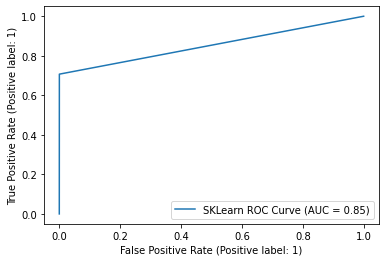

Model run: ff1d3a062b814109b36d24f8133b5635


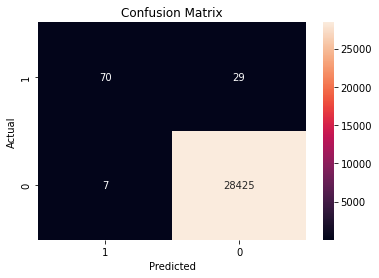

In [29]:
sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg')

mlflow.set_experiment('sklearn_experiment')
with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, 'log_reg_model')
    print('Model run:', mlflow.active_run().info.run_uuid)
mlflow.end_run()


## Loading a Logged Model

In [30]:
loaded_model = mlflow.sklearn.load_model('runs:/ff1d3a062b814109b36d24f8133b5635/log_reg_model')

In [31]:
loaded_model.score(x_test, y_test)

0.9987382145736217

# Model Validation (Parameter Tunning)

## Parameter Tunnig - Broad Search

In [32]:
anomaly_weights = [1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [33]:
mlflow.set_experiment('sklearn_creditcard_broad_search')

logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f]

            mlflow.log_param('anomaly_weight', weight)

            class_weights = {0: 1, 1: weight}

            sk_model = LogisticRegression(
                random_state=None,
                solver='newton-cg',
                class_weight=class_weights
            ).fit(x_validate[train], y_validate[train])

            for h in range(40): print('-', end='')
            print(f'\nfold {fold}\nAnomaly Weight: {weight}')

            train_acc = sk_model.score(x_validate[train], y_validate[train])

            mlflow.log_metric('train_acc', train_acc)

            eval_acc = sk_model.score(x_validate[test], y_validate[test])
            preds = sk_model.predict(x_validate[test])

            mlflow.log_metric('eval_acc', eval_acc)

            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            
            mlflow.log_metric('auc_score', auc_score)

            print(f'AUC: {auc_score}\neval_acc: {eval_acc}')

            accuracies.append(eval_acc)
            auc_scores.append(auc_score)

            log = [sk_model, x_validate[test], y_validate[test], preds]
            logs.append(log)

            mlflow.sklearn.log_model(sk_model, f'anom_weight_{weight}_fold_{fold}')

            fold = fold + 1
            mlflow.end_run()
    print('\nAverages: ')
    print('Accuracy: ', np.mean(accuracies))
    print('AUC: ', np.mean(auc_scores))
    print('Best: ')
    print('Accuracy: ', np.max(accuracies))
    print('AUC: ', np.max(auc_scores))


2022/01/05 11:25:19 INFO mlflow.tracking.fluent: Experiment with name 'sklearn_creditcard_broad_search' does not exist. Creating a new experiment.


----------------------------------------
fold 1
Anomaly Weight: 1
AUC: 0.8
eval_acc: 0.9985982127212195
----------------------------------------
fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval_acc: 0.998422712933754
----------------------------------------
fold 3
Anomaly Weight: 1
AUC: 0.8406451922461774
eval_acc: 0.9982474588152822
----------------------------------------
fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval_acc: 0.9987732211706976
----------------------------------------
fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval_acc: 0.9989484752891693

Averages: 
Accuracy:  0.9985980161860246
AUC:  0.8437245395411569
Best: 
Accuracy:  0.9989484752891693
AUC:  0.8682452129973255
----------------------------------------
fold 1
Anomaly Weight: 5
AUC: 0.8748241603657465
eval_acc: 0.9987734361310671
----------------------------------------
fold 2
Anomaly Weight: 5
AUC: 0.975398919462244
eval_acc: 0.9982474588152822
----------------------------------------
fold 3
Anomaly

## Parameter Tunning - Guided Search

In [35]:
anomaly_weights = [10, 15, 100, 150, 200]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [36]:
mlflow.set_experiment('sklearn_creditcard_guided_search')

logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f]

            mlflow.log_param('anomaly_weight', weight)

            class_weights = {0: 1, 1: weight}

            sk_model = LogisticRegression(
                random_state=None,
                solver='newton-cg',
                class_weight=class_weights
            ).fit(x_validate[train], y_validate[train])

            for h in range(40): print('-', end='')
            print(f'\nfold {fold}\nAnomaly Weight: {weight}')

            train_acc = sk_model.score(x_validate[train], y_validate[train])

            mlflow.log_metric('train_acc', train_acc)

            eval_acc = sk_model.score(x_validate[test], y_validate[test])
            preds = sk_model.predict(x_validate[test])

            mlflow.log_metric('eval_acc', eval_acc)

            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            
            mlflow.log_metric('auc_score', auc_score)

            print(f'AUC: {auc_score}\neval_acc: {eval_acc}')

            accuracies.append(eval_acc)
            auc_scores.append(auc_score)

            log = [sk_model, x_validate[test], y_validate[test], preds]
            logs.append(log)

            mlflow.sklearn.log_model(sk_model, f'anom_weight_{weight}_fold_{fold}')

            fold = fold + 1
            mlflow.end_run()
    print('\nAverages: ')
    print('Accuracy: ', np.mean(accuracies))
    print('AUC: ', np.mean(auc_scores))
    print('Best: ')
    print('Accuracy: ', np.max(accuracies))
    print('AUC: ', np.max(auc_scores))


2022/01/05 12:06:18 INFO mlflow.tracking.fluent: Experiment with name 'sklearn_creditcard_guided_search' does not exist. Creating a new experiment.


----------------------------------------
fold 1
Anomaly Weight: 10
AUC: 0.9243845612801126
eval_acc: 0.9982477659015244
----------------------------------------
fold 2
Anomaly Weight: 10
AUC: 0.9753109687146626
eval_acc: 0.9980722046968104
----------------------------------------
fold 3
Anomaly Weight: 10
AUC: 0.9313783507133262
eval_acc: 0.9985979670522257
----------------------------------------
fold 4
Anomaly Weight: 10
AUC: 0.8943851628367561
eval_acc: 0.9985979670522257
----------------------------------------
fold 5
Anomaly Weight: 10
AUC: 0.8820013855427915
eval_acc: 0.9985979670522257

Averages: 
Accuracy:  0.9984227743510024
AUC:  0.9214920858175297
Best: 
Accuracy:  0.9985979670522257
AUC:  0.9753109687146626
----------------------------------------
fold 1
Anomaly Weight: 15
AUC: 0.9242966414629858
eval_acc: 0.9980725424916769
----------------------------------------
fold 2
Anomaly Weight: 15
AUC: 0.9751350672194998
eval_acc: 0.9977216964598669
-------------------------------

# Local Model Serving

## Deploying the model

In [1]:
import pandas as pd 
import mlflow
import mlflow.sklearn

import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix

import numpy as np
import subprocess
import json 



In [2]:
# mlflow models serve --model-uri runs:/ff1d3a062b814109b36d24f8133b5635/log_reg_model -p 1234

In [3]:
URL = 'https://github.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/blob/master/creditcard.csv?raw=true'

df = pd.read_csv(URL)

In [4]:
input_json = df.iloc[:80].drop(['Time', 'Class'], axis=1).to_json(orient='split')

## Querying Without Scaling

In [6]:
proc = subprocess.run(
    [
        "curl", 
        "-X", 
        "POST", 
        "-H", 
        "Content-Type:application/json; format=pandas-split", 
        "--data", 
        input_json, 
        "http://127.0.0.1:5000/invocations"
    ], 
    stdout=subprocess.PIPE, encoding='utf-8'
)

output = proc.stdout
df2 = pd.DataFrame([json.loads(output)])
df2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28942  100   240  100 28702  14117  1648k --:--:-- --:--:-- --:--:-- 1662k


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,0,1,1,1,0,0,1,1,0,...,1,0,0,0,0,0,1,1,0,0


In [7]:
y_true = df.iloc[:80].Class
df2 = df2.T
eval_acc = accuracy_score(y_true, df2)

y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true, df2)

print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.6625
Eval AUC 0.3291139240506329


/home/caio-mac/miniconda3/envs/mlflow-beta/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Querying with Scaling

In [8]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)

scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop(["Time", "Class"], axis=1))

StandardScaler()

In [9]:
scaled_selection = scaler.transform(df.iloc[:80].drop(['Time', 'Class'], axis=1))
input_json = pd.DataFrame(scaled_selection).to_json(orient='split')

In [11]:
proc = subprocess.run(
    [
        "curl", 
        "-X", 
        "POST", 
        "-H", 
        "Content-Type:application/json; format=pandas-split", 
        "--data", 
        input_json, 
        "http://127.0.0.1:5000/invocations"
    ], 
    stdout=subprocess.PIPE, encoding='utf-8'
)

output = proc.stdout
preds = pd.DataFrame([json.loads(output)])
preds

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31775  100   240  100 31535  20000  2566k --:--:-- --:--:-- --:--:-- 2585k


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
y_true = df.iloc[:80].Class
preds = preds.T
eval_acc = accuracy_score(y_true, preds)

y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true, preds)

print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.9875
Eval AUC 0.5


/home/caio-mac/miniconda3/envs/mlflow-beta/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Batch Querying

In [13]:
test = df.iloc[:8000]
true = test.Class
test = scaler.transform(test.drop(["Time", "Class"], axis=1))
preds = []

batch_size = 80
for f in range(100):
    sample = pd.DataFrame(test[f*batch_size:(f+1)*batch_size]).to_json(orient="split")
    proc = subprocess.run(
        [
            "curl", 
            "-X", 
            "POST", 
            "-H",
            "Content-Type:application/json; format=pandas-split", 
            "--data", 
            sample, 
            "http://127.0.0.1:5000/invocations"
        ],
        stdout=subprocess.PIPE, encoding='utf-8'
    )

    output = proc.stdout
    resp = pd.DataFrame([json.loads(output)])
    preds = np.concatenate((preds, resp.values[0]))

eval_acc = accuracy_score(true, preds)
eval_auc = roc_auc_score(true, preds)

print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31775  100   240  100 31535  20000  2566k --:--:-- --:--:-- --:--:-- 2585k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31762  100   240  100 31522  20000  2565k --:--:-- --:--:-- --:--:-- 2584k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31730  100   240  100 31490  20000  2562k --:--:-- --:--:-- --:--:-- 2582k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31781  100   240  100 31541  20000  2566k --:--:-- --:--:-- --:--:-- 2586k
  % Total    % Received % Xferd  Average Speed   Tim

Eval Acc 0.9995
Eval AUC 0.9230769230769231


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31746  100   240  100 31506  20000  2563k --:--:-- --:--:-- --:--:-- 2818k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31764  100   240  100 31524  21818  2798k --:--:-- --:--:-- --:--:-- 2819k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31786  100   240  100 31546  21818  2800k --:--:-- --:--:-- --:--:-- 2821k


In [14]:
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.9995
Eval AUC 0.9230769230769231


Text(0.5, 1.0, 'Confusion Matrix')

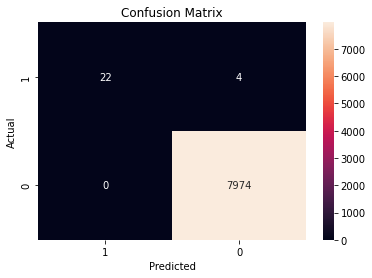

In [15]:
conf_matrix = confusion_matrix(true, preds)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")